## Inference Using Sarvam Translate Model on Flores plus dataset

In [ ]:
import os
import json
import torch
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from dotenv import load_dotenv
from huggingface_hub import login
from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset
from evaluate import load


In [ ]:
warnings.filterwarnings("ignore")
load_dotenv()
login(token=os.getenv("HUGGINGFACE_TOKEN"))

In [ ]:
# data for doi_Deva  not in Flores Plus
# Do inference for mni_Mtei
# In_langs = ['asm_Beng','ben_Beng','brx_Deva','doi_Deva','eng_Latn','gom_Deva','guj_Gujr','hin_Deva','kan_Knda','kas_Arab','kas_Deva','mai_Deva','mal_Mlym','mar_Deva','mni_Beng','mni_Mtei','npi_Deva','ory_Orya','pan_Guru','san_Deva','sat_Olck','snd_Arab','snd_Deva','tam_Taml','tel_Telu','urd_Arab']
In_langs = ['asm_Beng','ben_Beng','brx_Deva','eng_Latn','gom_Deva','guj_Gujr','hin_Deva','kan_Knda','kas_Arab','kas_Deva','mai_Deva','mal_Mlym','mar_Deva','mni_Beng','mni_Mtei','npi_Deva','ory_Orya','pan_Guru','san_Deva','sat_Olck','snd_Arab','snd_Deva','tam_Taml','tel_Telu','urd_Arab']


In [ ]:
code_lang_map = {
    'asm_Beng': 'Assamese',
    'ben_Beng': 'Bengali',
    'brx_Deva': 'Bodo',
    'doi_Deva':'Dogri',
    'eng_Latn': 'English',
    'gom_Deva': 'Konkani',
    'guj_Gujr': 'Gujarati',
    'hin_Deva': 'Hindi',
    'kan_Knda': 'Kannada',
    'kas_Arab': 'Kashmiri Arabic Script',
    'kas_Deva': 'Kahmiri Devangiri Script',
    'mai_Deva': 'Maithili',
    'mal_Mlym': 'Malayalam',
    'mar_Deva': 'Marathi',
    'mni_Beng':'Meiteilon Bengali Script',
    'mni_Mtei': 'Meiteilon Script',
    'npi_Deva': 'Nepali',
    'ory_Orya': 'Odia',
    'pan_Guru': 'Punjabi',
    'san_Deva': 'Sanskrit',
    'sat_Olck': 'Santali',
    'snd_Arab' : 'Sindhi Arabic Script',
    'snd_Deva': 'Sindhi Devangari Script',
    'tam_Taml': 'Tamil',
    'tel_Telu': 'Telugu',
    'urd_Arab': 'Urdu'
}

In [ ]:
lang_code_map = {
    'Assamese': 'asm_Beng',
    'Bengali': 'ben_Beng',
    'Bodo': 'brx_Deva',
    'Dogri': 'doi_Deva',
    'English': 'eng_Latn',
    'Konkani': 'gom_Deva',
    'Gujarati': 'guj_Gujr',
    'Hindi': 'hin_Deva',
    'Kannada': 'kan_Knda',
    'Kashmiri Arabic Script': 'kas_Arab',
    'Kahmiri Devangiri Script': 'kas_Deva',
    'Maithili': 'mai_Deva',
    'Malayalam': 'mal_Mlym',
    'Marathi': 'mar_Deva',
    'Meiteilon Bengali Script':'mni_Beng',
    'Meiteilon Script': 'mni_Mtei',
    'Nepali': 'npi_Deva',
    'Odia': 'ory_Orya',
    'Punjabi': 'pan_Guru',
    'Sanskrit': 'san_Deva',
    'Santali': 'sat_Olck',
    'Sindhi Devangari Script': 'snd_Deva',
    'Sindhi Arabic Script': 'snd_Arab',
    'Tamil': 'tam_Taml',
    'Telugu': 'tel_Telu',
    'Urdu': 'urd_Arab'
}
    

In [ ]:
ds={}

In [ ]:
for lan in In_langs:
    ds[lan] = load_dataset("openlanguagedata/flores_plus",lan,split='dev')

In [32]:
ds.keys()

dict_keys(['asm_Beng', 'ben_Beng', 'brx_Deva', 'eng_Latn', 'gom_Deva', 'guj_Gujr', 'hin_Deva', 'kan_Knda', 'kas_Arab', 'kas_Deva', 'mai_Deva', 'mal_Mlym', 'mar_Deva', 'mni_Beng', 'mni_Mtei', 'npi_Deva', 'ory_Orya', 'pan_Guru', 'san_Deva', 'sat_Olck', 'snd_Arab', 'snd_Deva', 'tam_Taml', 'tel_Telu', 'urd_Arab'])

In [ ]:
ds['eng_Latn']['text'][:5]

In [ ]:
model_name = "sarvamai/sarvam-translate"

In [ ]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to('cuda:0')

In [33]:
# All the translations will be saved in this dict
results={}

In [34]:
# Load existing results if available
try:
    with open("translations_sarvam_flores.json", "r",encoding="utf-8") as f:
        results = json.load(f)
except:
    print("File does not exist")

In [35]:
def translate(sentences, src_lang,tgt_lang, batch_size=1):
    model.eval()
    translations = []
    print("**"*20, end=" ")
    print(f"Translating from {src_lang} to {tgt_lang}",end=" ")
    print("**"*20)
    with torch.inference_mode():
        for i in range(0, len(sentences), batch_size):
            batch = sentences[i:i+batch_size]

            # Build messages for each sentence in the batch
            messages = [
                [
                    {"role": "system", "content": f"Translate the text below from {src_lang} to {tgt_lang}."},
                    {"role": "user", "content": sent}
                ]
                for sent in batch
            ]

            # Apply chat template to each
            inputs = [tokenizer.apply_chat_template(m, tokenize=False, add_generation_prompt=True) for m in messages]

            # Tokenize and move to device
            model_inputs = tokenizer(inputs, return_tensors="pt", padding="max_length", max_length=1024, truncation=True).to(model.device)

            # Generate
            generated_ids = model.generate(
                **model_inputs,
                max_new_tokens=1024,
                do_sample=False,
                # temperature=0.01,
                num_return_sequences=1
            )

            # Decode only new tokens for each sentence
            for j, gen in enumerate(generated_ids):
                output_ids = gen[len(model_inputs.input_ids[j]):].tolist()
                output_text = tokenizer.decode(output_ids, skip_special_tokens=True)
                translations.append(output_text.strip())
            
            print(f"Processed {src_lang}-{tgt_lang} {i + len(batch)}/{len(sentences)} sentences", end='\r')
            
            # Clean up to save memory
            del model_inputs, generated_ids
            torch.cuda.empty_cache()

    return translations

Indian to Indain languages translation is not supported by this model. Indian to English and English to Indian is alone possible.

## English to Indian Language Translation

In [36]:
for src_lang in ['eng_Latn']:
    if src_lang not in results:
        results[src_lang] = {}
    for tgt_lang in In_langs:
        if results[src_lang].get(f'{src_lang}-{tgt_lang}'):
            print(f"Skipping {src_lang} to {tgt_lang}, already exists.")
            continue
        out = translate(ds[src_lang]['text'], code_lang_map[src_lang], code_lang_map[tgt_lang])
        results[src_lang][f'{src_lang}-{tgt_lang}'] = out

        # One every translation pair, save to a file

        try:
            with open("translations_sarvam_flores.json", "w", encoding="utf-8") as f:
                json.dump(results, f, indent=4, ensure_ascii=False)
                print(f"File saved as of {tgt_lang}")
        except IOError as e:
            print(f"Error saving file: {e}")

Skipping eng_Latn to asm_Beng, already exists.
Skipping eng_Latn to ben_Beng, already exists.
Skipping eng_Latn to brx_Deva, already exists.
Skipping eng_Latn to eng_Latn, already exists.
Skipping eng_Latn to gom_Deva, already exists.
Skipping eng_Latn to guj_Gujr, already exists.
Skipping eng_Latn to hin_Deva, already exists.
Skipping eng_Latn to kan_Knda, already exists.
Skipping eng_Latn to kas_Arab, already exists.
Skipping eng_Latn to kas_Deva, already exists.
Skipping eng_Latn to mai_Deva, already exists.
Skipping eng_Latn to mal_Mlym, already exists.
Skipping eng_Latn to mar_Deva, already exists.
Skipping eng_Latn to mni_Beng, already exists.
Skipping eng_Latn to mni_Mtei, already exists.
Skipping eng_Latn to npi_Deva, already exists.
Skipping eng_Latn to ory_Orya, already exists.
Skipping eng_Latn to pan_Guru, already exists.
Skipping eng_Latn to san_Deva, already exists.
Skipping eng_Latn to sat_Olck, already exists.
Skipping eng_Latn to snd_Arab, already exists.
Skipping eng_

## Indian Languages to English Translation

In [37]:
for src_lang in In_langs:
    if src_lang not in results:
        results[src_lang] = {}
    for tgt_lang in ['eng_Latn']:
        if results[src_lang].get(f'{src_lang}-{tgt_lang}'):
            print(f"Skipping {src_lang} to {tgt_lang}, already exists.")
            continue
        out = translate(ds[src_lang]['text'], code_lang_map[src_lang], code_lang_map[tgt_lang])
        results[src_lang][f'{src_lang}-{tgt_lang}'] = out

        # One every translation pair, save to a file

        try:
            with open("translations_sarvam_flores.json", "w", encoding="utf-8") as f:
                json.dump(results, f, indent=4, ensure_ascii=False)
                print(f"File saved as of {tgt_lang}",end='\n')
        except IOError as e:
            print(f"Error saving file: {e}")

Skipping asm_Beng to eng_Latn, already exists.
Skipping ben_Beng to eng_Latn, already exists.
Skipping brx_Deva to eng_Latn, already exists.
Skipping eng_Latn to eng_Latn, already exists.
Skipping gom_Deva to eng_Latn, already exists.
Skipping guj_Gujr to eng_Latn, already exists.
Skipping hin_Deva to eng_Latn, already exists.
Skipping kan_Knda to eng_Latn, already exists.
Skipping kas_Arab to eng_Latn, already exists.
Skipping kas_Deva to eng_Latn, already exists.
Skipping mai_Deva to eng_Latn, already exists.
Skipping mal_Mlym to eng_Latn, already exists.
Skipping mar_Deva to eng_Latn, already exists.
Skipping mni_Beng to eng_Latn, already exists.
Skipping mni_Mtei to eng_Latn, already exists.
Skipping npi_Deva to eng_Latn, already exists.
Skipping ory_Orya to eng_Latn, already exists.
Skipping pan_Guru to eng_Latn, already exists.
Skipping san_Deva to eng_Latn, already exists.
Skipping sat_Olck to eng_Latn, already exists.
Skipping snd_Arab to eng_Latn, already exists.
Skipping snd_

In [38]:
results['eng_Latn'].keys()

dict_keys(['eng_Latn-asm_Beng', 'eng_Latn-ben_Beng', 'eng_Latn-brx_Deva', 'eng_Latn-eng_Latn', 'eng_Latn-gom_Deva', 'eng_Latn-guj_Gujr', 'eng_Latn-hin_Deva', 'eng_Latn-kan_Knda', 'eng_Latn-kas_Arab', 'eng_Latn-kas_Deva', 'eng_Latn-mai_Deva', 'eng_Latn-mal_Mlym', 'eng_Latn-mar_Deva', 'eng_Latn-mni_Beng', 'eng_Latn-npi_Deva', 'eng_Latn-ory_Orya', 'eng_Latn-pan_Guru', 'eng_Latn-san_Deva', 'eng_Latn-sat_Olck', 'eng_Latn-snd_Arab', 'eng_Latn-snd_Deva', 'eng_Latn-tam_Taml', 'eng_Latn-tel_Telu', 'eng_Latn-urd_Arab', 'eng_Latn-mni_Mtei'])

## Evaluation with chrF++

In [39]:
chrf = load("chrf")

In [40]:
evaluation_results = {}

In [41]:
def reshape_to_2D(lst):
    return np.array(lst).reshape(-1,1).tolist()

In [43]:
for src_lang in In_langs:
    evaluation_results[src_lang] = {}
    for tgt_lang in In_langs:
        pair = f'{src_lang}-{tgt_lang}'
        if pair not in results[src_lang]:
            continue
        print(f"Evaluating {src_lang}-{tgt_lang}")
        # print(results[src_lang][pair][0])
        # print(ds[src_lang][0])
        eval_score = chrf.compute(predictions=results[src_lang][pair], references=reshape_to_2D(ds[tgt_lang]['text']), word_order = 2)
        evaluation_results[src_lang][pair] = round(eval_score['score'])

Evaluating asm_Beng-eng_Latn
Evaluating ben_Beng-eng_Latn
Evaluating brx_Deva-eng_Latn
Evaluating eng_Latn-asm_Beng
Evaluating eng_Latn-ben_Beng
Evaluating eng_Latn-brx_Deva
Evaluating eng_Latn-eng_Latn
Evaluating eng_Latn-gom_Deva
Evaluating eng_Latn-guj_Gujr
Evaluating eng_Latn-hin_Deva
Evaluating eng_Latn-kan_Knda
Evaluating eng_Latn-kas_Arab
Evaluating eng_Latn-kas_Deva
Evaluating eng_Latn-mai_Deva
Evaluating eng_Latn-mal_Mlym
Evaluating eng_Latn-mar_Deva
Evaluating eng_Latn-mni_Beng
Evaluating eng_Latn-mni_Mtei
Evaluating eng_Latn-npi_Deva
Evaluating eng_Latn-ory_Orya
Evaluating eng_Latn-pan_Guru
Evaluating eng_Latn-san_Deva
Evaluating eng_Latn-sat_Olck
Evaluating eng_Latn-snd_Arab
Evaluating eng_Latn-snd_Deva
Evaluating eng_Latn-tam_Taml
Evaluating eng_Latn-tel_Telu
Evaluating eng_Latn-urd_Arab
Evaluating gom_Deva-eng_Latn
Evaluating guj_Gujr-eng_Latn
Evaluating hin_Deva-eng_Latn
Evaluating kan_Knda-eng_Latn
Evaluating kas_Arab-eng_Latn
Evaluating kas_Deva-eng_Latn
Evaluating mai

In [44]:
evaluation_results

{'asm_Beng': {'asm_Beng-eng_Latn': 50},
 'ben_Beng': {'ben_Beng-eng_Latn': 53},
 'brx_Deva': {'brx_Deva-eng_Latn': 47},
 'eng_Latn': {'eng_Latn-asm_Beng': 40,
  'eng_Latn-ben_Beng': 50,
  'eng_Latn-brx_Deva': 44,
  'eng_Latn-eng_Latn': 90,
  'eng_Latn-gom_Deva': 44,
  'eng_Latn-guj_Gujr': 54,
  'eng_Latn-hin_Deva': 58,
  'eng_Latn-kan_Knda': 52,
  'eng_Latn-kas_Arab': 34,
  'eng_Latn-kas_Deva': 1,
  'eng_Latn-mai_Deva': 46,
  'eng_Latn-mal_Mlym': 53,
  'eng_Latn-mar_Deva': 50,
  'eng_Latn-mni_Beng': 4,
  'eng_Latn-mni_Mtei': 45,
  'eng_Latn-npi_Deva': 53,
  'eng_Latn-ory_Orya': 51,
  'eng_Latn-pan_Guru': 53,
  'eng_Latn-san_Deva': 29,
  'eng_Latn-sat_Olck': 32,
  'eng_Latn-snd_Arab': 2,
  'eng_Latn-snd_Deva': 39,
  'eng_Latn-tam_Taml': 55,
  'eng_Latn-tel_Telu': 55,
  'eng_Latn-urd_Arab': 52},
 'gom_Deva': {'gom_Deva-eng_Latn': 45},
 'guj_Gujr': {'guj_Gujr-eng_Latn': 56},
 'hin_Deva': {'hin_Deva-eng_Latn': 58},
 'kan_Knda': {'kan_Knda-eng_Latn': 52},
 'kas_Arab': {'kas_Arab-eng_Latn': 

## Visualize Results

In [45]:
dataframe = pd.DataFrame(columns=In_langs, index= In_langs)

In [46]:
for src_lang, targets in evaluation_results.items():
    for target_key, score in targets.items():
        tgt_lang = target_key.split("-")[1]
        dataframe.loc[src_lang,tgt_lang] = score

In [47]:
dataframe = dataframe.fillna(0)

In [48]:
dataframe

,asm_Beng,ben_Beng,brx_Deva,eng_Latn,gom_Deva,guj_Gujr,hin_Deva,kan_Knda,kas_Arab,kas_Deva,...,npi_Deva,ory_Orya,pan_Guru,san_Deva,sat_Olck,snd_Arab,snd_Deva,tam_Taml,tel_Telu,urd_Arab
asm_Beng,0,0,0,50,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ben_Beng,0,0,0,53,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
brx_Deva,0,0,0,47,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
eng_Latn,40,50,44,90,44,54,58,52,34,1,...,53,51,53,29,32,2,39,55,55,52
gom_Deva,0,0,0,45,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
guj_Gujr,0,0,0,56,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
hin_Deva,0,0,0,58,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
kan_Knda,0,0,0,52,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
kas_Arab,0,0,0,45,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
kas_Deva,0,0,0,36,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


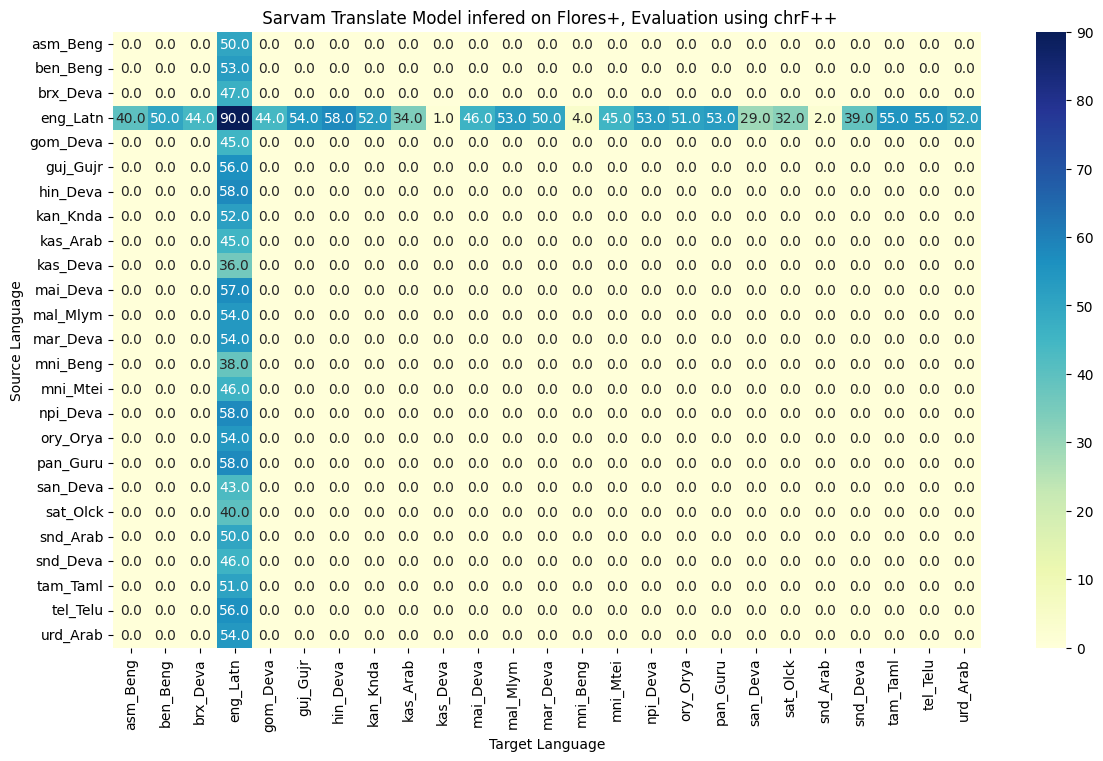

In [49]:
plt.figure(figsize=(14,8))
sns.heatmap(data=dataframe,annot=True, fmt='.1f', cmap='YlGnBu' )
plt.xlabel("Target Language")
plt.ylabel("Source Language")
plt.title(" Sarvam Translate Model infered on Flores+, Evaluation using chrF++")
plt.show()

The Translation pairs Eng to kas_deva, Eng to min_Beng are Eng to snd_Arab are producing poor results.
The model's translation is good for the same langugae pair as earlier but with differnt script.